# Load SOAR Data (for training)
This notebook is a minimal example of how to load the RLDS SOAR data (e.g. for downstream training)

In [1]:

"""
1. Download a minimal SOAR dataset that's small to be used for testing

In this notebook we load a small dummy dataset for speed. If you wish to load the full dataset, 
use the download script in this directory to download the full dataset. Then it can be loaded
in the same way, changing the path to the saved dataset.
"""
import os
import subprocess

# use the downloading bash script, but pass in the path to the dummy dataset
SAVE_DIR = os.path.expanduser("~/dummy_soar_data")
URL_FILE = os.path.join(os.getcwd(), "test_dataset_urls.txt")

# call the bashscript
command = f"SAVE_DIR={SAVE_DIR} URL_FILE={URL_FILE} REQUIRED_SPACE_GB=0.4 bash download_dataset.sh"
print(f"Executing command: {command}")
subprocess.run(command, shell=True, stderr=subprocess.DEVNULL)

Executing command: SAVE_DIR=/home/paulzhou/dummy_soar_data URL_FILE=/home/paulzhou/research/soar/soar_data/test_dataset_urls.txt REQUIRED_SPACE_GB=0.4 bash download_dataset.sh
Saving files to /home/paulzhou/dummy_soar_data


CompletedProcess(args='SAVE_DIR=/home/paulzhou/dummy_soar_data URL_FILE=/home/paulzhou/research/soar/soar_data/test_dataset_urls.txt REQUIRED_SPACE_GB=0.4 bash download_dataset.sh', returncode=0)

In [ ]:
"""
2. Import the Dataloader class
"""
# install jaxrl_m if it it not already installed
# the package is located in model_training/jaxrl_m
try:
    import jaxrl_m
except ImportError:
    print("local jaxrl_m package not installed")
    jaxrl_m_path = os.path.abspath(os.path.join(os.getcwd(), "..", "model_training"))
    os.system(f"pip install -e {jaxrl_m_path}")
    
    # add the package path to sys.path
    import sys
    
    
# check that installation was successful
try:
    import jaxrl_m
except ImportError:
    print("Failed to correctly install jaxrl_m package")
    print("Please manually install the package with `pip install -e model_training`")
    exit(1)

# import dataloader class
from jaxrl_m.data.dataset import WidowXDataset

In [ ]:
"""
3. Load the dataset
"""
train_data = WidowXDataset(
    [SAVE_DIR],
    seed=0,
    batch_size=16,
    train=True,
)

2024-07-30 02:11:34.807796: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7f34008ea0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-30 02:11:34.807843: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1722330694.919631  149399 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-07-30 02:11:34.920520: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-30 02:11:34.920658: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-30 02:11:34.922528: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-30 02:11:34.922785: E external/local_xla/xla/stream_executor/stream_executor_interna

Example batch keys: dict_keys(['observations', 'next_observations', 'actions', 'terminals'])
Actions shape: (16, 7), which is (batch_size, action_dim)
Observations shape: (16, 256, 256, 3), which is (batch_size, observation_dim)
Proprio shape: (16, 7), which is (batch_size, proprio_dim)


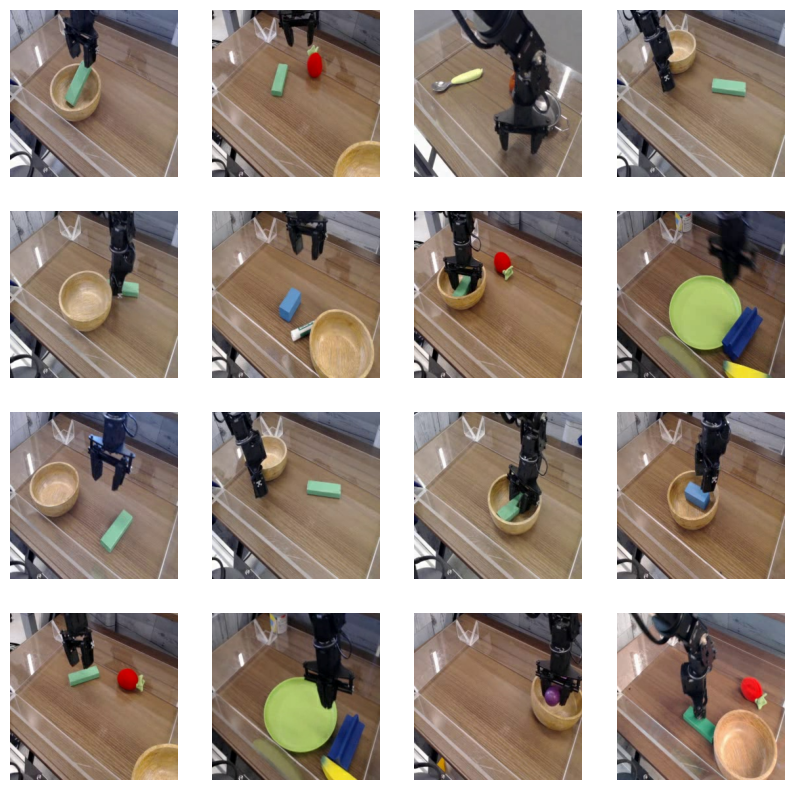

In [4]:
"""
4. Inspect an example batch
"""
import matplotlib.pyplot as plt

train_data_iter = train_data.iterator()
example_batch = next(train_data_iter)

print(f"Example batch keys: {example_batch.keys()}")
print(f"Actions shape: {example_batch['actions'].shape}, which is (batch_size, action_dim)")
print(f"Observations shape: {example_batch['observations']['image'].shape}, which is (batch_size, observation_dim)")
print(f"Proprio shape: {example_batch['observations']['proprio'].shape}, which is (batch_size, proprio_dim)")

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(example_batch['observations']['image'][i])
    plt.axis('off')
plt.show()

In [ ]:
"""
5. Load only the success/failure split of the SOAR-data
If you wish, you could only load certain splits of the dataset. 
"""
success_data = WidowXDataset(
    [SAVE_DIR],
    data_splits=["success"],
    seed=0,
    batch_size=16,
    train=True,
)

failure_data = WidowXDataset(
    [SAVE_DIR],
    data_splits=["failure"],
    seed=0,
    batch_size=16,
    train=True,
)

## More Advanced Usage
For more advanced usage, check out the arguments of the `BridgeDataset` class at [model_training/jaxrl_m/data/dataset.py](https://github.com/rail-berkeley/soar/blob/main/model_training/jaxrl_m/data/dataset.py).

An example of how this dataset is used is in `model_training/experiments/train.py`, and the configuration and arguments of the datasets are in `model_training/experiments/configs/train_config.py` and `model_training/experiments/configs/data_config.py`.